In [151]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import glob
import utils
import matplotlib.colors as colors
import cmaps
from statsmodels.nonparametric.smoothers_lowess import lowess as  sm_lowess
from scipy.stats import pearsonr, t as tdist
from scipy.stats import t

In [152]:
def pvalue_array(x,y,dname):
    x_an=x-x.mean(dname)
    y_an=y-y.mean(dname)
    slope=(x_an*y_an).sum(dname)/(x_an*x_an).sum(dname)
    interc=y.mean(dname)-slope*x.mean(dname)
    ypred=slope*x+interc
    n=len(x[dname])
    mse=np.sqrt(((y-ypred)**2).sum(dname)/(n-2))
    xsq=np.sqrt(((x_an)**2).sum(dname))
    standerr=mse/xsq
    pval=2*(1-t.cdf(np.abs(slope/standerr),n-2))
    pval=xr.DataArray(pval,dims=standerr.dims,coords=standerr.coords)
    return pval

def rvalue_array(x,y,dname):
    xmean=x.mean(dname)
    ymean=y.mean(dname)
    numer=(x*y).mean(dname)-xmean*ymean
    denom=np.sqrt(((x**2).mean(dname)-xmean**2)*(((y**2).mean(dname))-(ymean**2)))
    return numer/denom

def regcoeff_array(x,y,dname):
    x_an=x-x.mean(dname)
    y_an=y-y.mean(dname)
    slope=(x_an*y_an).sum(dname)/(x_an*x_an).sum(dname)
    return slope

def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg, skipna=True)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

In [ ]:
datadir='/data/ghervieux/AFI'
plotdir='/home/ghervieux/SCRIPTS/GEV/PLOTS'

# GLOST 

In [56]:
fileGLOST = f'{datadir}/NOAA_GLOST_anomaly.csv'
df_glost=pd.read_csv(fileGLOST,skiprows=4)
df_glost['Year']=pd.to_datetime(df_glost['Year'], format='%Y%m')

In [65]:
ds_glost=df_glost.set_index(['Year']).to_xarray()
sm_x, smooth_glost = sm_lowess(ds_glost['Anomaly'], ds_glost['Year'],  frac=(30*12)/len(ds_glost['Year']), 
                           it=5, return_sorted = True).T
smooth_glost=xr.DataArray(smooth_glost,dims=['time'],coords={'time':ds_glost['Year'].data})  

In [66]:
def ann_mean(var):
    month_length = var.time.dt.days_in_month
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()
    var_ann = (var*wgts).groupby("time.year").sum()
    return var_ann

In [67]:
ann_glost=ann_mean(smooth_glost)
ann_glost=ann_glost.rename({'year':'time'})

Text(0.5, 1.0, 'GLOST timeseries')

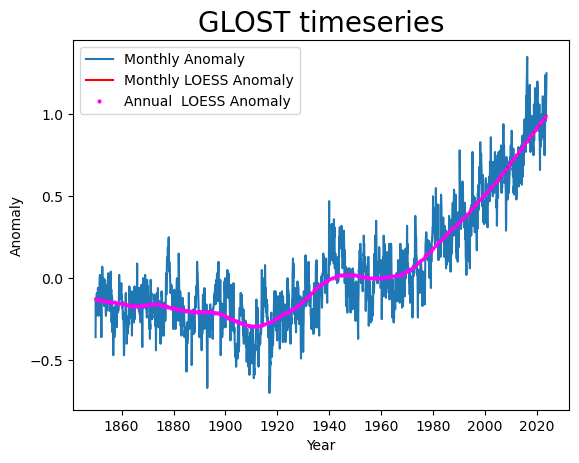

In [69]:
xxx=[np.datetime64(str(ann_glost['time'].data[it])) for it in range(0,len(ann_glost['time']))]

ds_glost['Anomaly'].plot(label='Monthly Anomaly')
plt.plot(ds_glost['Year'], smooth_glost, color='red',label='Monthly LOESS Anomaly')
plt.plot(xxx, ann_glost,marker='o', linestyle='', color='magenta',markersize=2,label='Annual  LOESS Anomaly')
plt.legend()
plt.title('GLOST timeseries',fontsize=20)

# Read Daily ERA5 temperature

In [3]:
min_lat=72;max_lat=24
min_lon=180;max_lon=305

In [49]:
yearb=1941
yeare=2023
temp_var='air'
year=np.arange(yearb,yeare+1,1)

In [4]:
dsm=xr.open_dataset('/data/ghervieux/AFI/mask_usa_for_ERA5crop.nc')
mask=dsm['mask_usa'].load()

In [37]:
ifile=f'{datadir}/air.DJF.2m.{yearb}.nc'
ds=xr.open_dataset(ifile)

In [52]:
air_DJFmean = np.zeros((len(year),len(ds['lat']),len(ds['lon'])))
air_DJFvar  = np.zeros((len(year),len(ds['lat']),len(ds['lon'])))
air_DJFmean = xr.DataArray(air_DJFmean,dims=['year','lat','lon'],\
                           coords={'year':year,\
                                   'lat':ds['lat'],\
                                    'lon':ds['lon']})
air_DJFvar = xr.DataArray(air_DJFvar,dims=['year','lat','lon'],\
                           coords={'year':year,\
                                   'lat':ds['lat'],\
                                    'lon':ds['lon']})


In [53]:
for iyear in year:
  ifile = f'{datadir}/air.DJF.2m.{iyear}.nc'
  ds = xr.open_dataset(ifile)
  air_DJFmean.loc[{'year':iyear,'lat':ds['lat'],'lon':ds['lon']}]=ds['air'].mean('time')
  air_DJFvar.loc[{'year':iyear,'lat':ds['lat'],'lon':ds['lon']}]=ds['air'].var('time')

## Regression 

In [73]:
ann_glost = ann_glost.sel(time=slice(yearb,yeare))
ann_glost = ann_glost.rename({'time':'year'})

In [86]:
reg_mean = regcoeff_array(air_DJFmean,ann_glost,'year')
reg_var  = regcoeff_array(air_DJFvar ,ann_glost,'year')

In [95]:
reg_mean = reg_mean.where(mask==1)
reg_var = reg_var.where(mask==1)

In [ ]:
print(reg_mean.min(),reg_mean.max())
print(reg_var.min(),reg_var.max())

<xarray.DataArray ()> Size: 8B
array(0.00313422) <xarray.DataArray ()> Size: 8B
array(0.19958896)
<xarray.DataArray ()> Size: 8B
array(-0.05512474) <xarray.DataArray ()> Size: 8B
array(0.04757705)


In [82]:
state_borders = cartopy.feature.NaturalEarthFeature(category='cultural',\
                     name='admin_1_states_provinces_lakes', scale='50m', facecolor='None')

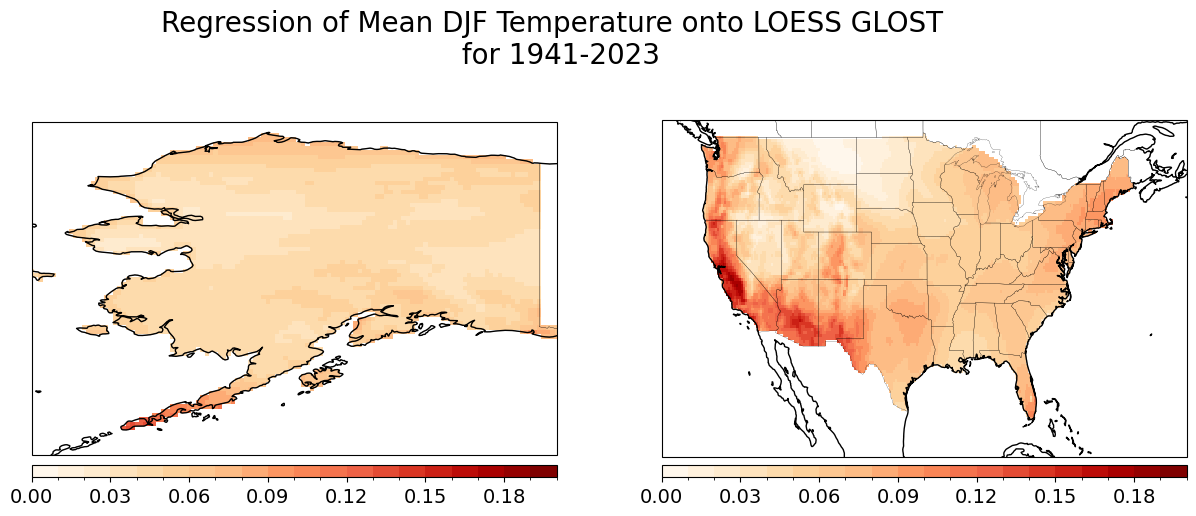

In [181]:
cmap='OrRd'
proj=ccrs.PlateCarree()

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,6),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15, right=0.95)
cc=reg_mean.plot.pcolormesh(ax=ax[0],cmap=cmap,levels=np.arange(0,0.21,0.01),add_colorbar=False)
p0 = ax[0].get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0], 0.2, p0[2]-p0[0], 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar,shrink=0.5,orientation='horizontal')
cbar.ax.tick_params(labelsize=14)  
cbar.set_label(label='',fontsize=16)
ax[0].set_extent([190,220,53,72],ccrs.PlateCarree())

cc=reg_mean.plot.pcolormesh(ax=ax[1],cmap=cmap,levels=np.arange(0,0.21,0.01),add_colorbar=False)
p0 = ax[1].get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0], 0.2, p0[2]-p0[0], 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar,shrink=0.5,orientation='horizontal')
cbar.ax.tick_params(labelsize=14)  
cbar.set_label(label='',fontsize=16)
ax[1].set_extent([230,300,22,50.5],ccrs.PlateCarree())


asp = np.diff(ax[0].get_xlim())[0] / np.diff(ax[0].get_ylim())[0]
ax[1].set_aspect(asp)

for i in range(len(ax)):
  ax[i].add_feature(state_borders,zorder=100,edgecolor='k',linewidth=0.15)
  ax[i].coastlines()
  ax[i].set_title('')
plt.suptitle(f'Regression of Mean DJF Temperature onto LOESS GLOST \n for {yearb}-{yeare}',fontsize=20)  
outfile=f'PLOTS/Regression_DJFmean_Temp_GLOST_{yearb}_{yeare}.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

Map of regression between the DJF mean of daily ERA5 Temperature and the 30year-smoothed GLOST (LOESS) for the period 1941-2023. 

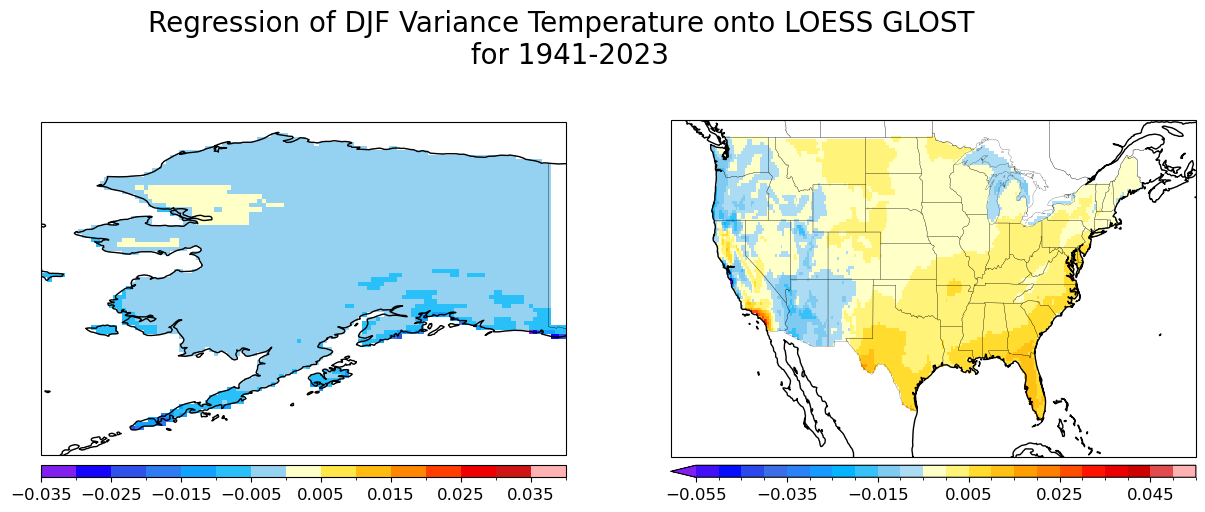

In [182]:
cmap=cmaps.ncl_default
proj=ccrs.PlateCarree()

clevs = np.arange(-0.035,0.04,0.005)
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,6),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15, right=0.95)
cc=reg_var.sel(lon=slice(190,220),lat=slice(72,53)).plot.pcolormesh(ax=ax[0],cmap=cmap,levels=clevs,add_colorbar=False)
p0 = ax[0].get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0], 0.2, p0[2]-p0[0], 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar,ticks=clevs[::2],shrink=0.5,orientation='horizontal')
cbar.ax.tick_params(labelsize=12)  
cbar.set_label(label='',fontsize=16)
ax[0].set_extent([190,220,53,72],ccrs.PlateCarree())

clevs = np.arange(-0.055,0.06,0.005)
cc=reg_var.sel(lon=slice(230,300),lat=slice(50.5,22)).plot.pcolormesh(ax=ax[1],cmap=cmap,levels=clevs,add_colorbar=False)
p0 = ax[1].get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0], 0.2, p0[2]-p0[0], 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar,ticks=clevs[::4],shrink=0.5,orientation='horizontal')
cbar.ax.tick_params(labelsize=12)  
cbar.set_label(label='',fontsize=16)
ax[1].set_extent([230,300,22,50.5],ccrs.PlateCarree())


asp = np.diff(ax[0].get_xlim())[0] / np.diff(ax[0].get_ylim())[0]
ax[1].set_aspect(asp)

for i in range(len(ax)):
  ax[i].add_feature(state_borders,zorder=100,edgecolor='k',linewidth=0.15)
  ax[i].coastlines()
  ax[i].set_title('')
plt.suptitle(f'Regression of DJF Variance Temperature onto LOESS GLOST \n for {yearb}-{yeare}',fontsize=20)  
outfile=f'PLOTS/Regression_DJFvar_Temp_GLOST_{yearb}_{yeare}.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

Map of regression between the DJF variance of daily ERA5 Temperature and the 30year-smoothed GLOST (LOESS) for the period 1941-2023. The grey contour marks where the p-value is < 0.01.

## Correlation 

In [183]:
cor_mean = rvalue_array(air_DJFmean,ann_glost,'year')
cor_var  = rvalue_array(air_DJFvar ,ann_glost,'year')
cor_mean = cor_mean.where(mask==1)
cor_var = cor_var.where(mask==1)

In [184]:
pvalue_mean = pvalue_array(air_DJFmean,ann_glost,'year')
pvalue_var  = pvalue_array(air_DJFvar ,ann_glost,'year')
pvalue_mean = pvalue_mean.where(mask==1)
pvalue_var = pvalue_var.where(mask==1)

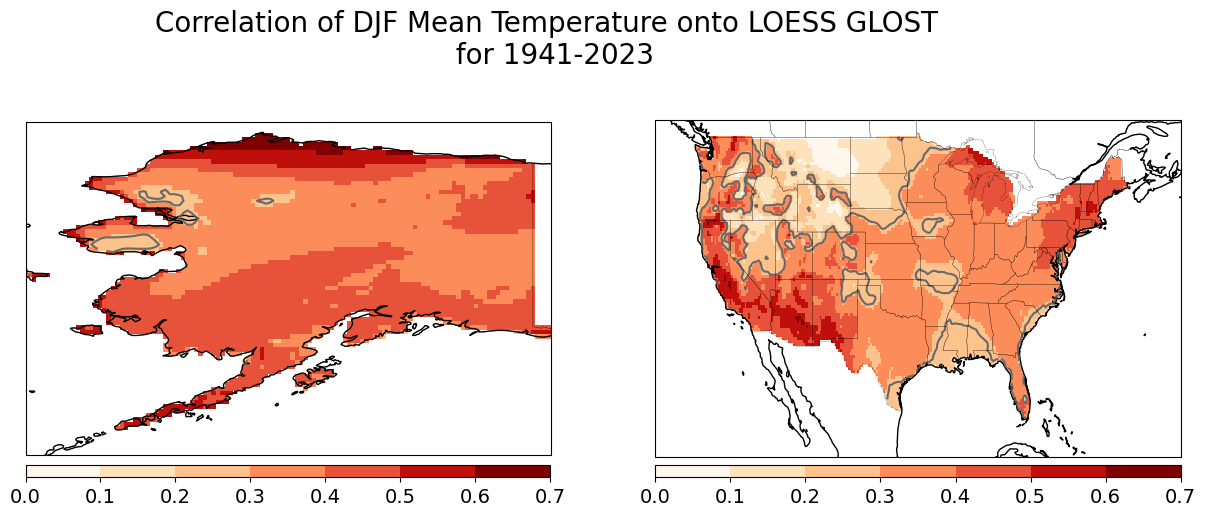

In [185]:
cmap='OrRd'
proj=ccrs.PlateCarree()

clevs = np.arange(0.,.8,0.1)
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,6),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15, right=0.95)
cc=cor_mean.plot.pcolormesh(ax=ax[0],cmap=cmap,levels=clevs,add_colorbar=False)
ax[0].contour(ds['lon'],ds['lat'],pvalue_mean,levels=[0.01],colors='dimgrey')
p0 = ax[0].get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0], 0.2, p0[2]-p0[0], 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar,shrink=0.5,orientation='horizontal')
cbar.ax.tick_params(labelsize=14)  
cbar.set_label(label='',fontsize=16)
ax[0].set_extent([190,220,53,72],ccrs.PlateCarree())

cc=cor_mean.plot.pcolormesh(ax=ax[1],cmap=cmap,levels=clevs,add_colorbar=False)
ax[1].contour(ds['lon'],ds['lat'],pvalue_mean,levels=[0.01],colors='dimgrey')
p0 = ax[1].get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0], 0.2, p0[2]-p0[0], 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar,shrink=0.5,orientation='horizontal')
cbar.ax.tick_params(labelsize=14)  
cbar.set_label(label='',fontsize=16)
ax[1].set_extent([230,300,22,50.5],ccrs.PlateCarree())


asp = np.diff(ax[0].get_xlim())[0] / np.diff(ax[0].get_ylim())[0]
ax[1].set_aspect(asp)

for i in range(len(ax)):
  ax[i].add_feature(state_borders,zorder=100,edgecolor='k',linewidth=0.15)
  ax[i].coastlines()
  ax[i].set_title('')
plt.suptitle(f'Correlation of DJF Mean Temperature onto LOESS GLOST \n for {yearb}-{yeare}',fontsize=20)  
outfile=f'PLOTS/Correlation_DJFmean_Temp_GLOST_{yearb}_{yeare}.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

Map of correlation between the DJF mean of daily ERA5 Temperature and the 30year-smoothed GLOST (LOESS) for the period 1941-2023. The grey contour marks where the p-value is < 0.01.

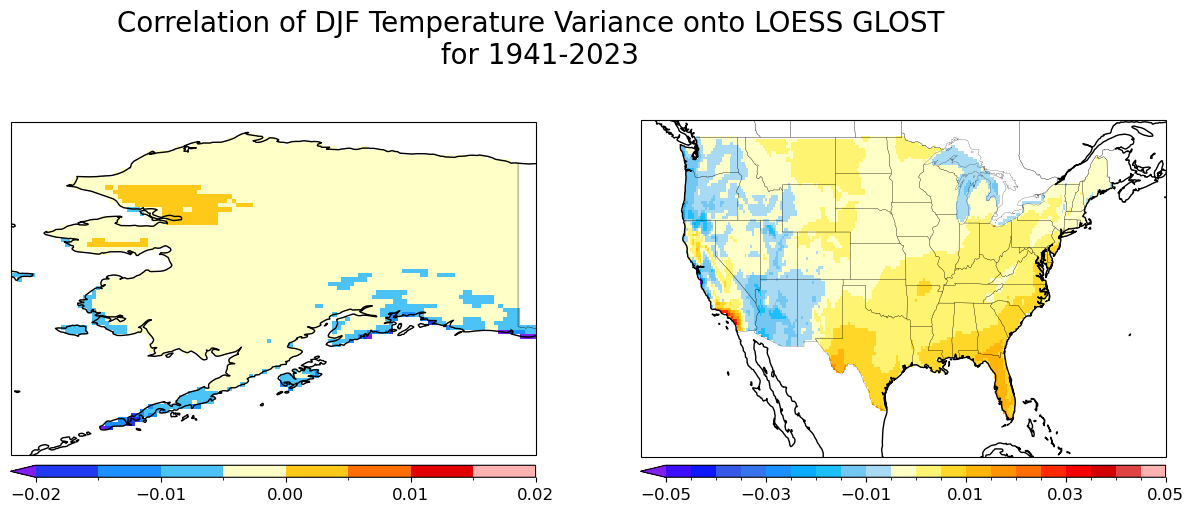

In [186]:
cmap=cmaps.ncl_default
proj=ccrs.PlateCarree()

clevs = np.arange(-0.02,0.025,0.005)
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,6),subplot_kw={'projection':proj})
#ax[0].contour(ds['lon'],ds['lat'],pvalue_var,levels=[0.01],colors='dimgrey')
plt.subplots_adjust(bottom=0.15, right=0.95)
cc=reg_var.sel(lon=slice(190,220),lat=slice(72,53)).plot.pcolormesh(ax=ax[0],levels=clevs,cmap=cmap,add_colorbar=False)
p0 = ax[0].get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0], 0.2, p0[2]-p0[0], 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar,ticks=clevs[::2],shrink=0.5,orientation='horizontal')
cbar.ax.tick_params(labelsize=12)  
cbar.set_label(label='',fontsize=16)
ax[0].set_extent([190,220,53,72],ccrs.PlateCarree())

clevs = np.arange(-0.05,0.055,0.005)
cc=reg_var.sel(lon=slice(230,300),lat=slice(50.5,22)).plot.pcolormesh(ax=ax[1],levels=clevs,cmap=cmap,add_colorbar=False)
#ax[1].contour(ds['lon'],ds['lat'],pvalue_var,levels=[0.01],colors='dimgrey')
p0 = ax[1].get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0], 0.2, p0[2]-p0[0], 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar,ticks=clevs[::4],shrink=0.5,orientation='horizontal')
cbar.ax.tick_params(labelsize=12)  
cbar.set_label(label='',fontsize=16)
ax[1].set_extent([230,300,22,50.5],ccrs.PlateCarree())


asp = np.diff(ax[0].get_xlim())[0] / np.diff(ax[0].get_ylim())[0]
ax[1].set_aspect(asp)

for i in range(len(ax)):
  ax[i].add_feature(state_borders,zorder=100,edgecolor='k',linewidth=0.15)
  ax[i].coastlines()
  ax[i].set_title('')
plt.suptitle(f'Correlation of DJF Temperature Variance onto LOESS GLOST \n for {yearb}-{yeare}',fontsize=20)  
outfile=f'PLOTS/Correlation_DJFvar_Temp_GLOST_{yearb}_{yeare}.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

Map of correlation between the DJF variance of daily ERA5 Temperature and the 30year-smoothed GLOST (LOESS) for the period 1941-2023. 